In [46]:
import tensorflow as tf 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("ticks")
%matplotlib inline 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_mat=pd.read_csv("../process-data/Af_normed_response_mat.csv", index_col=False)

In [3]:
data_normed_mat=data_mat.iloc[:, :].as_matrix()

In [22]:
data_mat.columns[20]

'eaformalhouse'

In [ ]:
print(data_normed_mat.shape)

In [4]:
def lrelu(x, rate=0.1):
    # leaky relu
    return tf.maximum(tf.minimum(x*rate, 0), x)

def fc_bn_lrelu(inputs, num_outputs):
    # fully connected batch normalized, and leaky relu activation
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                             weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                             weights_regularizer=tf.contrib.layers.l2_regularizer(2.0e-5),
                                             activation_fn=tf.identity, scope=None )
    fc = tf.contrib.layers.batch_norm(fc)
    fc = lrelu(fc)
    return fc


def fc_bn_tanh(inputs, num_outputs):
    # fully connected batch normalized, and leaky relu activation
    fc = tf.contrib.layers.fully_connected(inputs, num_outputs,
                                             weights_initializer=tf.random_normal_initializer(stddev=0.02),
                                             weights_regularizer=tf.contrib.layers.l2_regularizer(2.0e-5),
                                             activation_fn=tf.identity, scope=None )
    fc = tf.contrib.layers.batch_norm(fc)
    fc = tf.nn.tanh(fc)
    return fc

In [44]:
## define inputs 
width = 34
inputs_ = tf.placeholder(tf.float32, (None, width), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, width), name='targets')

## Encoder 
hidden_dim = 1
e_l1 = fc_bn_lrelu(inputs_, 34)
e_l2 = fc_bn_lrelu(e_l1, 16)
e_l3 = fc_bn_lrelu(e_l2, 8)
encoded_mu = fc_bn_lrelu(e_l3, hidden_dim)
encoded_std = fc_bn_lrelu(e_l3, hidden_dim)
# reparameterization trick
noise = tf.random_normal([1, hidden_dim])
z = encoded_mu + tf.multiply(noise, tf.exp(.5*encoded_std))
## Decoder 
# d_l0 = fc_bn_lrelu(z, 2)
d_l1 = fc_bn_lrelu(z, 8)
d_l2 = fc_bn_lrelu(d_l1, 16)
d_l3 = fc_bn_lrelu(d_l2, 34)
d_l4 = fc_bn_lrelu(d_l3, width)
decoded = tf.nn.tanh(d_l4)
## 
loss = tf.losses.mean_pairwise_squared_error(labels=targets_, predictions=decoded, scope='loss')
opt = tf.train.AdamOptimizer(0.001).minimize(loss) 


###
##
# variational lower bound

# add epsilon to log to prevent numerical overflow
# log_likelihood = tf.reduce_sum(targets_*tf.log(decoded + 1e-9)+(1 - targets_)*tf.log(1 - decoded + 1e-9), reduction_indices=1)
# KL_term = -.5*tf.reduce_sum(1 + 2*encoded_std - tf.pow(encoded_mu,2) - tf.exp(2*encoded_std), reduction_indices=1)
# variational_lower_bound = tf.reduce_mean(log_likelihood - KL_term)
# # optimizer = tf.train.AdadeltaOptimizer().minimize(-variational_lower_bound)
# optimizer = tf.train.AdamOptimizer(0.02).minimize(-variational_lower_bound + loss)


In [45]:
sess = tf.Session()

epochs = 200
batch_size = 50
sess.run(tf.global_variables_initializer())
losses = []
for e in range(epochs):
    
    for ii in range( int(data_normed_mat.shape[0]/batch_size)):
        batch_ind = np.random.choice(int(data_normed_mat.shape[0]), batch_size, replace=False)        
        batch = data_normed_mat[batch_ind] 
        batch_cost, _ = sess.run([loss, opt], feed_dict={inputs_: batch,
                                                         targets_: batch})
#         batch_cost, _ = sess.run([variational_lower_bound, optimizer], feed_dict={inputs_: batch, targets_:batch})
        
        if ii % 20 == 0 : 
#             print((imgs.shape))
            print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))
        
        if e % 5 == 0 and ii % 50 == 0 :
            losses.append(batch_cost)

Epoch: 1/200... Training loss: 21.4945
Epoch: 1/200... Training loss: 13.6751
Epoch: 1/200... Training loss: 12.5713
Epoch: 1/200... Training loss: 12.0649
Epoch: 1/200... Training loss: 11.8119
Epoch: 1/200... Training loss: 10.6967
Epoch: 1/200... Training loss: 11.0739
Epoch: 2/200... Training loss: 10.1073
Epoch: 2/200... Training loss: 8.7286
Epoch: 2/200... Training loss: 9.4945
Epoch: 2/200... Training loss: 8.7356
Epoch: 2/200... Training loss: 9.3186
Epoch: 2/200... Training loss: 8.5109
Epoch: 2/200... Training loss: 8.8163
Epoch: 3/200... Training loss: 8.3820
Epoch: 3/200... Training loss: 8.4587
Epoch: 3/200... Training loss: 8.9016
Epoch: 3/200... Training loss: 8.2492
Epoch: 3/200... Training loss: 8.1903
Epoch: 3/200... Training loss: 7.8176
Epoch: 3/200... Training loss: 8.2012
Epoch: 4/200... Training loss: 7.6170
Epoch: 4/200... Training loss: 7.7673
Epoch: 4/200... Training loss: 7.4644
Epoch: 4/200... Training loss: 8.0987
Epoch: 4/200... Training loss: 7.5396
Epoc

Epoch: 31/200... Training loss: 6.1323
Epoch: 31/200... Training loss: 6.6891
Epoch: 31/200... Training loss: 6.3001
Epoch: 31/200... Training loss: 6.3969
Epoch: 32/200... Training loss: 6.7501
Epoch: 32/200... Training loss: 6.4672
Epoch: 32/200... Training loss: 6.2560
Epoch: 32/200... Training loss: 6.6920
Epoch: 32/200... Training loss: 6.8535
Epoch: 32/200... Training loss: 6.4034
Epoch: 32/200... Training loss: 7.3432
Epoch: 33/200... Training loss: 5.9156
Epoch: 33/200... Training loss: 6.8714
Epoch: 33/200... Training loss: 6.8562
Epoch: 33/200... Training loss: 6.3500
Epoch: 33/200... Training loss: 5.6337
Epoch: 33/200... Training loss: 5.5477
Epoch: 33/200... Training loss: 5.8444
Epoch: 34/200... Training loss: 6.3704
Epoch: 34/200... Training loss: 6.4590
Epoch: 34/200... Training loss: 6.0707
Epoch: 34/200... Training loss: 6.5426
Epoch: 34/200... Training loss: 6.4167
Epoch: 34/200... Training loss: 6.1790
Epoch: 34/200... Training loss: 5.9590
Epoch: 35/200... Training

Epoch: 61/200... Training loss: 5.9661
Epoch: 61/200... Training loss: 6.1095
Epoch: 62/200... Training loss: 6.5480
Epoch: 62/200... Training loss: 6.0946
Epoch: 62/200... Training loss: 6.5477
Epoch: 62/200... Training loss: 6.3291
Epoch: 62/200... Training loss: 5.8243
Epoch: 62/200... Training loss: 6.5300
Epoch: 62/200... Training loss: 6.2991
Epoch: 63/200... Training loss: 5.9344
Epoch: 63/200... Training loss: 6.0520
Epoch: 63/200... Training loss: 6.4141
Epoch: 63/200... Training loss: 6.1321
Epoch: 63/200... Training loss: 6.4412
Epoch: 63/200... Training loss: 6.1535
Epoch: 63/200... Training loss: 5.6340
Epoch: 64/200... Training loss: 6.7674
Epoch: 64/200... Training loss: 5.9046
Epoch: 64/200... Training loss: 6.7508
Epoch: 64/200... Training loss: 6.4780
Epoch: 64/200... Training loss: 6.7749
Epoch: 64/200... Training loss: 6.4484
Epoch: 64/200... Training loss: 6.1580
Epoch: 65/200... Training loss: 5.7411
Epoch: 65/200... Training loss: 5.3657
Epoch: 65/200... Training

Epoch: 91/200... Training loss: 6.0510
Epoch: 92/200... Training loss: 6.3004
Epoch: 92/200... Training loss: 7.2242
Epoch: 92/200... Training loss: 6.1151
Epoch: 92/200... Training loss: 5.7449
Epoch: 92/200... Training loss: 6.2266
Epoch: 92/200... Training loss: 6.2890
Epoch: 92/200... Training loss: 5.9783
Epoch: 93/200... Training loss: 5.2620
Epoch: 93/200... Training loss: 6.1051
Epoch: 93/200... Training loss: 5.6776
Epoch: 93/200... Training loss: 6.2176
Epoch: 93/200... Training loss: 5.5980
Epoch: 93/200... Training loss: 5.4978
Epoch: 93/200... Training loss: 5.8085
Epoch: 94/200... Training loss: 6.2139
Epoch: 94/200... Training loss: 6.5003
Epoch: 94/200... Training loss: 5.7232
Epoch: 94/200... Training loss: 6.1461
Epoch: 94/200... Training loss: 6.1710
Epoch: 94/200... Training loss: 6.2530
Epoch: 94/200... Training loss: 6.2214
Epoch: 95/200... Training loss: 6.0056
Epoch: 95/200... Training loss: 6.0196
Epoch: 95/200... Training loss: 6.4380
Epoch: 95/200... Training

Epoch: 121/200... Training loss: 5.5358
Epoch: 121/200... Training loss: 5.6867
Epoch: 121/200... Training loss: 6.3345
Epoch: 121/200... Training loss: 6.2405
Epoch: 122/200... Training loss: 6.6051
Epoch: 122/200... Training loss: 5.5273
Epoch: 122/200... Training loss: 5.9992
Epoch: 122/200... Training loss: 6.0165
Epoch: 122/200... Training loss: 5.7714
Epoch: 122/200... Training loss: 5.9560
Epoch: 122/200... Training loss: 6.0245
Epoch: 123/200... Training loss: 6.9266
Epoch: 123/200... Training loss: 5.8680
Epoch: 123/200... Training loss: 6.3909
Epoch: 123/200... Training loss: 6.1027
Epoch: 123/200... Training loss: 5.8553
Epoch: 123/200... Training loss: 6.8238
Epoch: 123/200... Training loss: 5.7669
Epoch: 124/200... Training loss: 5.9697
Epoch: 124/200... Training loss: 6.5617
Epoch: 124/200... Training loss: 6.6796
Epoch: 124/200... Training loss: 5.6799
Epoch: 124/200... Training loss: 6.1629
Epoch: 124/200... Training loss: 6.5249
Epoch: 124/200... Training loss: 6.6086


Epoch: 150/200... Training loss: 6.3551
Epoch: 151/200... Training loss: 5.8132
Epoch: 151/200... Training loss: 5.6686
Epoch: 151/200... Training loss: 5.8330
Epoch: 151/200... Training loss: 5.8247
Epoch: 151/200... Training loss: 6.2808
Epoch: 151/200... Training loss: 6.3989
Epoch: 151/200... Training loss: 5.2078
Epoch: 152/200... Training loss: 6.0048
Epoch: 152/200... Training loss: 5.4746
Epoch: 152/200... Training loss: 6.0043
Epoch: 152/200... Training loss: 6.3599
Epoch: 152/200... Training loss: 6.2353
Epoch: 152/200... Training loss: 5.9367
Epoch: 152/200... Training loss: 7.2095
Epoch: 153/200... Training loss: 5.8754
Epoch: 153/200... Training loss: 5.8486
Epoch: 153/200... Training loss: 5.7881
Epoch: 153/200... Training loss: 5.7975
Epoch: 153/200... Training loss: 5.5891
Epoch: 153/200... Training loss: 6.1530
Epoch: 153/200... Training loss: 6.6637
Epoch: 154/200... Training loss: 5.8720
Epoch: 154/200... Training loss: 5.6146
Epoch: 154/200... Training loss: 5.7507


Epoch: 180/200... Training loss: 5.8487
Epoch: 180/200... Training loss: 5.5748
Epoch: 180/200... Training loss: 5.8481
Epoch: 180/200... Training loss: 6.6409
Epoch: 180/200... Training loss: 6.3393
Epoch: 181/200... Training loss: 6.5086
Epoch: 181/200... Training loss: 5.5477
Epoch: 181/200... Training loss: 6.1118
Epoch: 181/200... Training loss: 6.7455
Epoch: 181/200... Training loss: 5.4749
Epoch: 181/200... Training loss: 6.0681
Epoch: 181/200... Training loss: 5.5759
Epoch: 182/200... Training loss: 6.0097
Epoch: 182/200... Training loss: 5.5191
Epoch: 182/200... Training loss: 5.8709
Epoch: 182/200... Training loss: 6.3984
Epoch: 182/200... Training loss: 5.6761
Epoch: 182/200... Training loss: 5.7456
Epoch: 182/200... Training loss: 6.6734
Epoch: 183/200... Training loss: 5.4362
Epoch: 183/200... Training loss: 5.5572
Epoch: 183/200... Training loss: 6.2486
Epoch: 183/200... Training loss: 5.8287
Epoch: 183/200... Training loss: 6.5359
Epoch: 183/200... Training loss: 5.3921


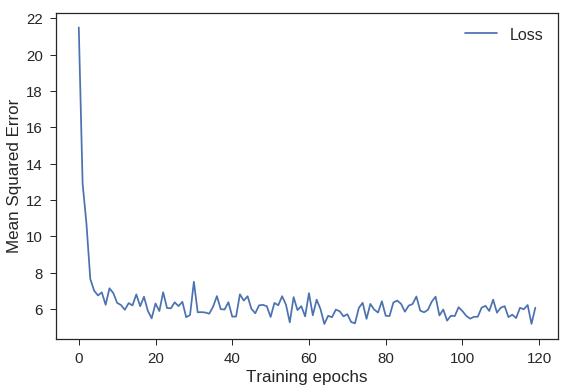

In [47]:
plt.figure(figsize=(9,6))
plt.plot(np.arange(len(losses)), losses, label="Loss")
plt.tick_params(labelsize=15)
plt.xlabel("Training epochs", fontsize=17)
plt.ylabel("Mean Squared Error", fontsize=17)
plt.legend(fontsize=16)


In [40]:
# decode 

reconstructed, enc_mu, enc_std = sess.run([decoded,encoded_mu, encoded_std], feed_dict={inputs_: data_normed_mat[2:4, :]})

In [41]:
print(enc_mu, enc_std)
z_encoded_index, l_before_tanh = sess.run([z, d_l4], feed_dict={inputs_: data_normed_mat[2:13, :]})
# print(indices)

[[ 0.92837995]
 [-0.10692241]] [[-0.29459876]
 [-0.49419507]]


In [28]:
# plt.plot(l_before_tanh[:2,].transpose())

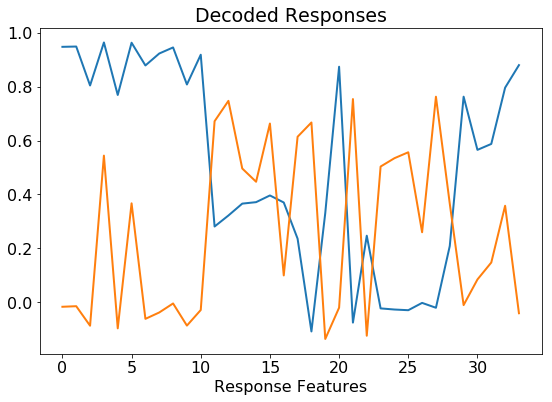

In [42]:
plt.figure(figsize=(9,6))
plt.title("Decoded Responses", fontsize=19)
plt.plot(reconstructed.transpose(), linewidth=2)
plt.xlabel("Response Features", fontsize=16)
plt.tick_params(labelsize=16)

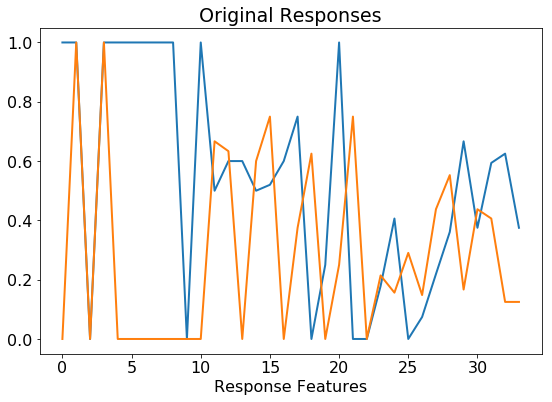

In [43]:
plt.figure(figsize=(9,6))
plt.title("Original Responses", fontsize=19)
plt.plot(data_normed_mat[2:4, :].transpose(), linewidth=2) 
plt.xlabel("Response Features", fontsize=16)
plt.tick_params(labelsize=16)